#**Практическое задание №1**

Установка необходимых пакетов:

In [ ]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


Монтирование Вашего Google Drive к текущему окружению:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [ ]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [ ]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown
import tensorflow as tf
import matplotlib.pyplot as plt

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [ ]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]
  
    def random_batch_with_labels(self, n, seed=1):
        np.random.seed(seed)
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:00<00:00, 134MB/s]


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 7.
Label code corresponds to STR class.


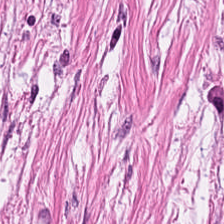

In [ ]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [ ]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Rescaling, RandomFlip, RandomRotation, Dropout, BatchNormalization
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pickle

In [ ]:
class Model:

    def __init__(self):
        self.model = tf.keras.Sequential()
        self.model.add(Input(shape=(224, 224, 3)))
        self.model.add(Rescaling(1./255))
        #LBL1 - аугментация
        self.model.add(RandomFlip("horizontal_and_vertical"))
        self.model.add(RandomRotation(0.3))

        self.model.add(Conv2D(96, (7, 7), padding='same', strides=2, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01)))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(MaxPool2D(pool_size=(3,3), strides=2))
        self.model.add(Conv2D(256, (5, 5), strides=2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01)))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(MaxPool2D(pool_size=(3,3), strides=2))
        
        self.model.add(Conv2D(384, (3, 3), padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01)))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(Conv2D(384, (3, 3), padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01)))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01)))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))

        self.model.add(MaxPool2D(pool_size=(3,3), strides=2))
        self.model.add(Flatten())

        self.model.add(Dense(4096, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01)))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(4096, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01)))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(9, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01)))
        self.model.add(Activation('softmax'))

        params = [{
            'C':[0.1, 1, 10, 100],
            'gamma':[0.01, 0.1, 1, 5],
            'kernel':['rbf']
        },
        {
            'C':[0.1, 1, 10, 100],
            'kernel':['linear']         
        }]
        self.classifier = RandomizedSearchCV(svm.SVC(), params, n_iter=10, cv=4, n_jobs=2, verbose=2)
        self.epochs = 80
        self.history = None

    def save(self, name: str):
        # example demonstrating saving the model to PROJECT_DIR folder on gdrive with name 'name'
        filename = f'/content/drive/MyDrive/{name}.h5'
        self.model.save_weights(filename, save_format='h5')
        f = open(f'/content/drive/MyDrive/{name}1', 'wb')
        pickle.dump([self.classifier, self.history], f)
        f.close()

    def load(self, name: str):
        # example demonstrating loading the model with name 'name' from gdrive using link
        name_to_id_dict = {
            'best_cnn': ['1XKw_ta_c8iRrib2MQXNDghE9UcDvVYd9', '1YKr3DQo7M--tjrFBVaxf3kvT-LzQ9iCy'],
            'best_cnn_1':['1MSkILgZiBiSpsuxv5xaCoKINtDghraW4','15wGPXh7VMO5GP_BUpsYgd7nDXQKHbhyu']
        }
        output = f'{name}.h5'
        gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id={name_to_id_dict[name][0]}", output, quiet=False)
        self.model.load_weights(output)
        output = f'{name}1'
        gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id={name_to_id_dict[name][1]}", output, quiet=False)
        f = open(output, 'rb')
        obj = pickle.load(f)
        self.classifier = obj[0]
        self.history = obj[1]
        f.close()

    def train(self, dataset: Dataset, only_classifiers=False):
        print(f'training started') 
        batch, batch1, batch_pred, batch_pred1 = train_test_split(dataset.images, dataset.labels, random_state=1147, test_size=0.33)

        if not only_classifiers:
            batch, batch_pred = shuffle(batch, batch_pred)
            batch_pred_new = np.zeros((batch.shape[0], len(TISSUE_CLASSES)))
            for i in range(batch.shape[0]):
                batch_pred_new[i][batch_pred[i]] = 1

            def scheduler(epoch, lr):
                if epoch < 15:
                    return lr
                else:
                    return lr * tf.math.exp(-0.07)
            #LBL2 - переменный learning rate
            callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
            self.model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                            loss='categorical_crossentropy',
                            metrics = 'accuracy')
            self.history = self.model.fit(batch, batch_pred_new, epochs=self.epochs, batch_size=32, callbacks=[callback])
            print(f'CNN is trained')

        batch1, batch_pred1 = shuffle(batch1, batch_pred1)
        new_batch = np.empty((batch1.shape[0], len(TISSUE_CLASSES)))
        for i in range(batch1.shape[0]):
            new_batch[i] = self.model(batch1[i].reshape((1, 224, 224, 3)), training=False)
        self.classifier.fit(new_batch, batch_pred1)
        print(f'training done')

    def train_visualize(self):
        #LBL3 - визуализация обучения
        acc = self.history.history['accuracy']
        loss = self.history.history['loss']
        epochs_range = np.arange(self.epochs)

        plt.plot(epochs_range, acc, label='Train accuracy', color='b')
        plt.legend()
        plt.title('Accuracy on train')
        plt.grid()
        plt.show()

        plt.plot(epochs_range, loss, label='Train loss', color='r')
        plt.legend()
        plt.title('Loss on train')
        plt.grid()
        plt.show()

    def test_on_dataset(self, dataset: Dataset, limit=None):
        # you can upgrade this code if you want to speed up testing using batches
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        img = img.reshape((1, 224, 224, 3))
        prediction = np.array(self.model(img, training=False))
        return self.classifier.predict(prediction)

---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test'.

In [ ]:
d_train = Dataset('train_small')
d_test = Dataset('test')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR
To: /content/train_small.npz
100%|██████████| 841M/841M [00:04<00:00, 174MB/s]


Loading dataset train_small from npz.
Done. Dataset train_small consists of 7200 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr
To: /content/test.npz
100%|██████████| 525M/525M [00:02<00:00, 194MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


In [ ]:
model = Model()

In [ ]:
if not EVALUATE_ONLY:
    model.train(d_train)
    model.save('best_cnn_1')
else:
    model.load('best_cnn_1')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1MSkILgZiBiSpsuxv5xaCoKINtDghraW4
To: /content/best_cnn_1.h5
100%|██████████| 233M/233M [00:03<00:00, 76.9MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=15wGPXh7VMO5GP_BUpsYgd7nDXQKHbhyu
To: /content/best_cnn_11
100%|██████████| 467M/467M [00:07<00:00, 59.2MB/s]


Визуализация обучения модели:

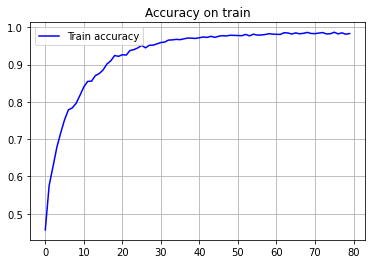

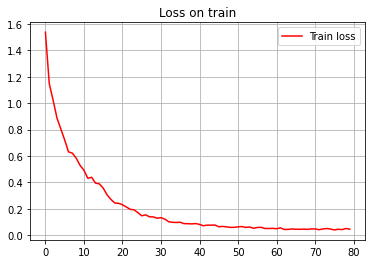

In [ ]:
#LBL3 - визуализация обучения
model.train_visualize()

Пример тестирования модели на части набора данных:

In [ ]:
# evaluating model on 20% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.2)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '20% of test')

  0%|          | 0/900 [00:00<?, ?it/s]

metrics for 20% of test:
	 accuracy 0.9933:
	 balanced accuracy 0.9938:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Пример тестирования модели на полном наборе данных:

In [ ]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

  0%|          | 0/4500 [00:00<?, ?it/s]

metrics for test:
	 accuracy 0.9731:
	 balanced accuracy 0.9731:


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

Матрица ошибок:

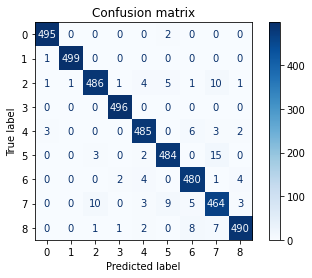

In [ ]:
#LBL4 - построение матрицы ошибок
ConfusionMatrixDisplay.from_predictions(np.array(pred_2).reshape(-1, 1), d_test.labels, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.show()

Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [ ]:
final_model = Model()
final_model.load('best_cnn_1')
d_test_tiny = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1MSkILgZiBiSpsuxv5xaCoKINtDghraW4
To: /content/best_cnn_1.h5
100%|██████████| 233M/233M [00:01<00:00, 186MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=15wGPXh7VMO5GP_BUpsYgd7nDXQKHbhyu
To: /content/best_cnn_11
100%|██████████| 467M/467M [00:02<00:00, 176MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1viiB0s041CNsAK4itvX8PnYthJ-MDnQc
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 70.6MB/s]


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


  0%|          | 0/90 [00:00<?, ?it/s]

metrics for test-tiny:
	 accuracy 0.9222:
	 balanced accuracy 0.9222:


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru. 

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb 

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"